# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

**Описание данных**
- Технологический процесс:
 - Rougher feed — исходное сырье
 - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
   - Xanthate **— ксантогенат (промотер, или активатор флотации);
   - Sulphate — сульфат (на данном производстве сульфид натрия);
   - Depressant — депрессант (силикат натрия).
 - Rougher process (англ. «грубый процесс») — флотация
 - Rougher tails — отвальные хвосты
 - Float banks — флотационная установка
 - Cleaner process — очистка
 - Rougher Au — черновой концентрат золота
 - Final Au — финальный концентрат золота

- Параметры этапов:
 - air amount — объём воздуха
 - fluid levels — уровень жидкости
 - feed size — размер гранул сырья
 - feed rate — скорость подачи

- Наименование признаков Наименование признаков должно быть такое:
       [этап].[тип_параметра].[название_параметра]

 - Возможные значения для блока [этап]:
   - rougher — флотация
   - primary_cleaner — первичная очистка
   - secondary_cleaner — вторичная очистка
   - final — финальные характеристики
 - Возможные значения для блока [тип_параметра]:
   - input — параметры сырья
   - output — параметры продукта 
   - state — параметры, характеризующие текущее состояние этапа
   - calculation — расчётные характеристики


## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

### Просмотр данных

Посмотрим на данные обучающей выборки

In [3]:
try: 
    df_train = pd.read_csv('/Users/iyaneklyudova/Downloads/gold_recovery_train.csv', index_col='date')
except:    
    df_train=pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date') # колонка date назначена индексом, 
                                                              #тк данные индексируются датой и временем получения информации
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

16860  строк и 86 колонок. Все колонки являются вещественными числами. В данных есть пропуски. Посмотрим сколько % составляют пропуски.

In [4]:
nan_number_train = df_train.isna().sum()/len(df_train)*100
display(nan_number_train)

final.output.concentrate_ag                            0.427046
final.output.concentrate_pb                            0.427046
final.output.concentrate_sol                           2.194543
final.output.concentrate_au                            0.421115
final.output.recovery                                  9.021352
final.output.tail_ag                                   0.391459
final.output.tail_pb                                   1.085409
final.output.tail_sol                                  0.860024
final.output.tail_au                                   0.391459
primary_cleaner.input.sulfate                          7.752076
primary_cleaner.input.depressant                       7.485172
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.842230
primary_cleaner.output.concentrate_ag                  0.486358
primary_cleaner.output.concentrate_pb                  2.123369
primary_cleaner.output.concentrate_sol  

В большинстве колонок пропуски небольшие, но есть несколько колонок с пропусками больше 10%. Необходима будет дальнейшая обработка пропуков

Посмотрим данные тестовой выборки

In [5]:
try: 
    df_test = pd.read_csv('/Users/iyaneklyudova/Downloads/gold_recovery_test.csv', index_col='date')
except:    
    df_test=pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date') # колонка date назначена индексом, 
                                                                 #тк данные индексируются датой и временем получения информации
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

5856 строк и 52 колонки. Колонок меньше, чем в обучающей выборке. В данных есть пропуски.  Все колонки вещественные числа.

Посмотрим на % пропусков

In [6]:
nan_number_test = df_test.isna().sum()/len(df_test)*100
display(nan_number_test)

primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                2.834699
primary_cleaner.state.floatbank8_a_air        0.273224
primary_cleaner.state.floatbank8_a_level      0.273224
primary_cleaner.state.floatbank8_b_air        0.273224
primary_cleaner.state.floatbank8_b_level      0.273224
primary_cleaner.state.floatbank8_c_air        0.273224
primary_cleaner.state.floatbank8_c_level      0.273224
primary_cleaner.state.floatbank8_d_air        0.273224
primary_cleaner.state.floatbank8_d_level      0.273224
rougher.input.feed_ag                         0.273224
rougher.input.feed_pb                         0.273224
rougher.input.feed_rate                       0.683060
rougher.input.feed_size                       0.375683
rougher.input.feed_sol                        1.144126
rougher.input.feed_au                         0.273224
rougher.in

Пропусков довольно мало. Максимум в одной колонке 5%. 

Посмотрим информацию по файлу со всеми данными. 

In [7]:
try: 
    df_full = pd.read_csv('/Users/iyaneklyudova/Downloads/gold_recovery_full.csv', index_col='date')
except:  
    df_full=pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date') # колонка date назначена индексом, тк данные индексируются датой и временем получения информации
df_full.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

22716 строк и 86 колонок. То есть в тестовой выгрузке 25% и в обучающей 75% данных. Нормальное разделение для обучения и тестирования модели. Все колонки вещественные числа. В данных также есть пропуски.
Посмотрим % пропусков

In [8]:
nan_number_full = df_full.isna().sum()/len(df_full)*100
display(nan_number_full)

final.output.concentrate_ag                            0.391794
final.output.concentrate_pb                            0.382990
final.output.concentrate_sol                           1.694841
final.output.concentrate_au                            0.378588
final.output.recovery                                  8.641486
final.output.tail_ag                                   0.365381
final.output.tail_pb                                   0.880437
final.output.tail_sol                                  1.192992
final.output.tail_au                                   0.356577
primary_cleaner.input.sulfate                          7.083113
primary_cleaner.input.depressant                       6.805776
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.066913
primary_cleaner.output.concentrate_ag                  0.431414
primary_cleaner.output.concentrate_pb                  1.972178
primary_cleaner.output.concentrate_sol  

В основном небольшие пропуски, в нескольких колонках 12-13% пропусков. 

### Проверка расчета эффективности обогащения

Напишем формулу для расчета эффективности обогащения:
- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки

Эффективность обогащения в наших данных это колонка **rougher.output.recovery**


In [9]:
# В срезах исключаем строки, где есть пропуски в колонке эффективности обогащения - rougher.output.recovery
C = df_train.loc[~df_train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = df_train.loc[~df_train['rougher.output.recovery'].isna(), 'rougher.input.feed_au'] 
T = df_train.loc[~df_train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
recovery_calc = abs(C*(F-T))/abs(F* (C-T))*100 # формула для расчета эффективности
print(len(C), len(F), len(T))

14287 14287 14287


В выборки для расчета попало одинаковое количество строк.

Сделаем выборку реальных показателей для сравнения расчета. 
Здесть так же берем данные, где нет пропусков у колонки **rougher.output.recovery** 

In [10]:
recovery_real = df_train.loc[~df_train['rougher.output.recovery'].isna(), 'rougher.output.recovery']
print(len(recovery_real))

14287


Количество строк такое же. Можно сравнить расчеты и посчитать МАЕ

In [11]:
print('Показатель MAE:', mean_absolute_error(recovery_real, recovery_calc))

Показатель MAE: 9.444891926100695e-15


Значение метрики оказалось маленьким, значит эффективность обогащения расчитана правильно

### Анализ  признаков, недоступных в тестовой выборке

Найдем колонки, которые есть в обучающей  выборке, но отсутсвуют в тестовой

In [12]:
[col for col in list(df_train.columns) if (col not in list(df_test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке на всех этапах отсутствуют данные по параметрам продукта (output): концентрация металлов(concentrate) и отвальные хвосты(tail) для этих металлов. Отсутствуют: эффективность обогащения чернового концентрата (rougher.output.recovery) и эффективность обогащения финального концентрата (final.output.recovery). Так же отсутствуют расчетные показатели (calculation) на этапе флотации. 
 

Для обучения модели будем использовать только те признаки, которые есть в тестовой выборке. Поэтому создадим список колонок, которые удалим из обучающей выборки перед обучением модели, кроме 2х колонок: **final.output.recovery** и **rougher.output.recovery**. Эти колонки будут целевыми признаками и понадобятся для обучения модели

In [13]:
drop_columns=['final.output.concentrate_ag','final.output.concentrate_pb',
 'final.output.concentrate_sol','final.output.concentrate_au',
 'final.output.tail_ag','final.output.tail_pb','final.output.tail_sol','final.output.tail_au',
 'primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol','primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag','primary_cleaner.output.tail_pb','primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au','rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed','rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio','rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol','rougher.output.concentrate_au',
 'rougher.output.tail_ag','rougher.output.tail_pb','rougher.output.tail_sol','rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag','secondary_cleaner.output.tail_pb','secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au']

### Предобработка данных.

Сначала заполним пропуски. Пропуски в колонке **rougher.output.recovery** можо заполнить по формуле расчета эффективности, которую мы проверили ранее. Но у колонок, необходимых для расчета, также имеются пропуски. Согласно вводной информаци данные индексируются датой и временем получения информации и  соседние по времени параметры часто похожи. Поэтому заполним пропуски в колонках, необходимых для расчета эффективности, значениями с соседних ячеек сверху.

In [14]:
df_train['rougher.output.concentrate_au'] = df_train['rougher.output.concentrate_au'].fillna(method='ffill')
df_train['rougher.input.feed_au'] = df_train['rougher.input.feed_au'].fillna(method='ffill')
df_train['rougher.output.tail_au'] = df_train['rougher.output.tail_au'].fillna(method='ffill')

Теперь заполним по формуле расчета эффекивности колонку **rougher.output.recovery**. 

In [15]:
C = df_train.loc[df_train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = df_train.loc[df_train['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = df_train.loc[df_train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
df_train.loc[df_train['rougher.output.recovery'].isna(), 'rougher.output.recovery']=  abs(C*(F-T))/abs(F* (C-T))*100
df_train['rougher.output.recovery'] =df_train['rougher.output.recovery'].replace(-np.inf, np.NaN) # чтобы избежать ошибочных значений 
                                                                                                 #из-за деления на ноль, заменим их на обычные пропуски
print('Доля пропущенных значений', df_train['rougher.output.recovery'].isna().sum()/len(df_train)*100)

Доля пропущенных значений 6.933570581257414


Доля пропусков уменьшилась с 15 до 7%.

К остальным данным также применим метод копирования данных с соседних ячеек

In [16]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

Проверим остались ли пропуски

In [17]:
df_train.isna().sum()

final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au                 0
primary_cleaner.output.tail_ag                  

In [18]:
df_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [19]:
df_full.isna().sum()

final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au                 0
primary_cleaner.output.tail_ag                  

**Выводы** 

Все данные в колонках одного типа.  Показатель расчета эффективности обогащения расчитан верно. Пропуски заполнены. 
Перед обучением модели необходимо будет удалить колонки из обучающей выборки (те, что отсутствуют в тестовой выборке)

## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Сначала посчитаем среднее значение по каждому метталу и этапу. 

In [20]:
ag_rougher=df_full['rougher.output.concentrate_ag'].mean()
ag_primary = df_full['primary_cleaner.output.concentrate_ag'].mean()
ag_final= df_full['final.output.concentrate_ag'].mean()
au_rougher=df_full['rougher.output.concentrate_au'].mean()
au_primary = df_full['primary_cleaner.output.concentrate_au'].mean()
au_final= df_full['final.output.concentrate_au'].mean()
pb_rougher=df_full['rougher.output.concentrate_pb'].mean()
pb_primary = df_full['primary_cleaner.output.concentrate_pb'].mean()
pb_final= df_full['final.output.concentrate_pb'].mean()


Посмотрим на заначения в таблице и построим график 

In [21]:
data = {'Этап обработки': ['rougher', 'primary', 'final'], 'AG': [ag_rougher, ag_primary,  ag_final], 
           'AU': [au_rougher, au_primary,  au_final],
           'PB': [pb_rougher, pb_primary,  pb_final]}
data_pivot = pd.DataFrame.from_dict(data)
display(data_pivot)


,Этап обработки,AG,AU,PB
0,rougher,10.845609,17.831509,6.886869
1,primary,7.666972,29.119967,8.809217
2,final,4.768013,39.891718,9.071366


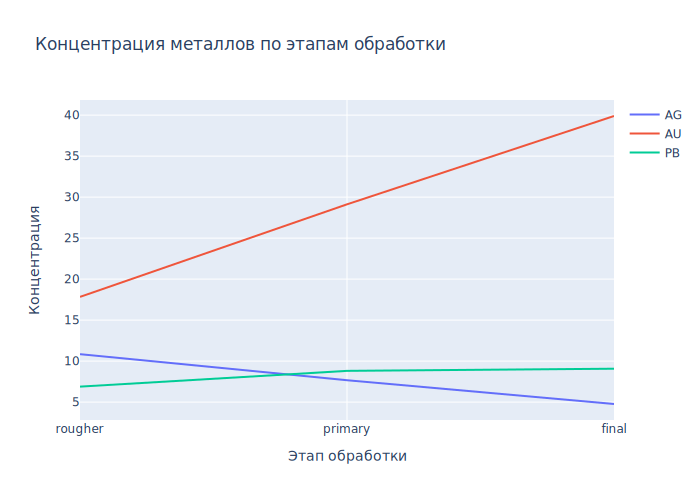

In [22]:
data_piv=pd.melt(data_pivot, id_vars=['Этап обработки'], value_vars=['AG', 'AU', 'PB'])
fig = px.line(data_piv, x='Этап обработки', y='value', color='variable',  labels=dict(value= "Концентрация", variable =""),title="Концентрация металлов по этапам обработки")
fig.show("svg")


С каждым следующим этапом концентрация золота растет, немного повышается концентраци свинца. А концентрация серебра падает. 

### Распределения размеров гранул сырья на обучающей и тестовой выборках

Посмторим на распределение на графике

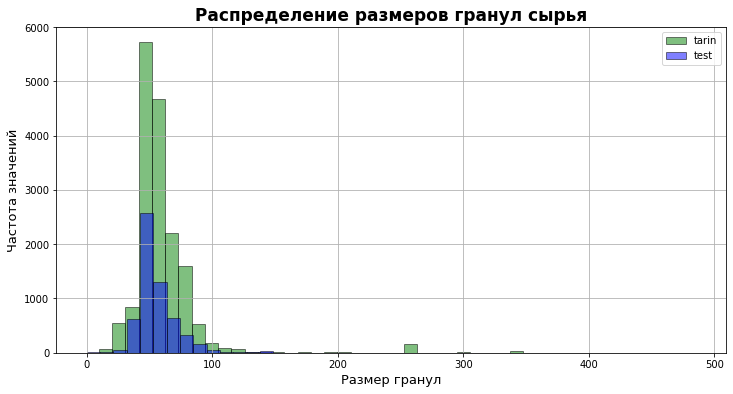

In [23]:
train_feed= df_train['rougher.input.feed_size'] # срез из обучащей выборки
test_feed= df_test['rougher.input.feed_size'] # срез из тестовой  выборки

ax = train_feed.plot(kind='hist', y='rougher.input.feed_size', ec='black' , bins=45, 
                              linewidth=1, alpha=0.5, label='tarin', color='g', legend=True,)
test_feed.plot(kind='hist', y='rougher.input.feed_size', ec='black',bins=45, linewidth=1, alpha=0.5, 
                         label='test', ax=ax, figsize=(12,6),grid=True, legend=True, color='b')

ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Размер гранул', fontsize=13)
ax.set_title('Распределение размеров гранул сырья', fontsize=17, fontweight='bold')
plt.show()

В целом похоже, хотя имеются некоторые выбросы. Посмотрим покрупнее.

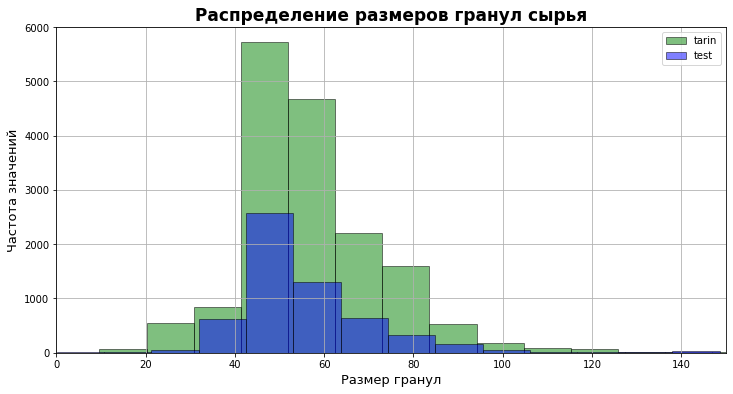

In [24]:
ax = train_feed.plot(kind='hist', y='rougher.input.feed_size', ec='black' , bins=45, 
                              linewidth=1, alpha=0.5, label='tarin', color='g', legend=True)
test_feed.plot(kind='hist', y='rougher.input.feed_size', ec='black',bins=45, linewidth=1, alpha=0.5, 
                         label='test', ax=ax, figsize=(12,6),grid=True, legend=True, color='b')
plt.xlim((0,150))
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Размер гранул', fontsize=13)
ax.set_title('Распределение размеров гранул сырья', fontsize=17, fontweight='bold')
plt.show()


По графику распределение в тестовой выборке повторяет распределение в обучающей выборке

### Исследование суммарной концентрации всех веществ на разных стадиях

Сначала посчитаем суммарную концентрацию всех веществ для каждой стадии и создадим в таблице дополнительные столбцы с суммой:
 - raw_total_concentr -концентрация веществ  в сырье (перед флотацией)
 - rougher_total_concentr - концентрация веществ в продукте после флотации
 - final_total_concentr - концентрация веществ в продукте после второй очистки

In [25]:
df_train['rougher_total_concentr']= df_train['rougher.output.concentrate_ag']+df_train['rougher.output.concentrate_pb']+df_train['rougher.output.concentrate_sol']+df_train['rougher.output.concentrate_au']
df_train['raw_total_concentr']= df_train['rougher.input.feed_ag']+df_train['rougher.input.feed_pb']+df_train['rougher.input.feed_sol']+df_train['rougher.input.feed_au']
df_train['final_total_concentr']= df_train['final.output.concentrate_ag']+df_train['final.output.concentrate_pb']+df_train['final.output.concentrate_sol']+df_train['final.output.concentrate_au']

In [26]:
display(df_train.head(3))

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_total_concentr,raw_total_concentr,final_total_concentr
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.4

Столбцы добавлены. Посмоторим на распределение на графике

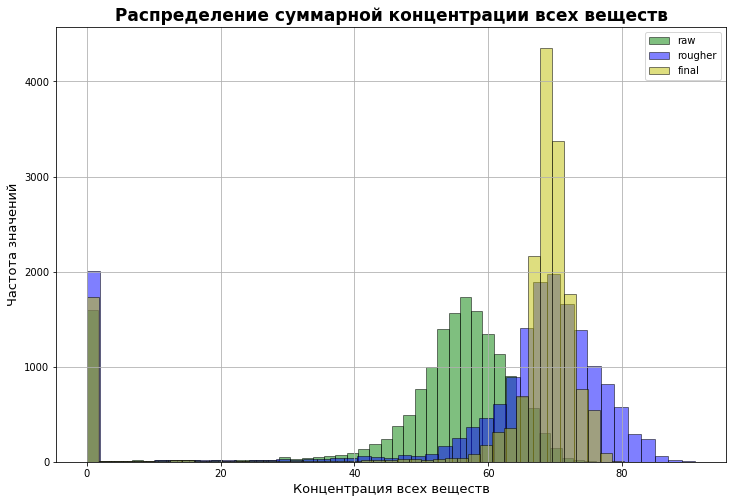

In [27]:
ax = df_train.plot(kind='hist', y='raw_total_concentr', ec='black' , bins=45, 
                              linewidth=1, alpha=0.5, label='raw', color='g', legend=True)
df_train.plot(kind='hist', y='rougher_total_concentr', ec='black',bins=45, linewidth=1, alpha=0.5, 
                         label='rougher', ax=ax, figsize=(12,8),grid=True, legend=True, color='b')
df_train.plot(kind='hist', y='final_total_concentr', ec='black',bins=45, linewidth=1, alpha=0.5, 
                         label='final', ax=ax, figsize=(12,8),grid=True, legend=True, color='y')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Концентрация всех веществ', fontsize=13)
ax.set_title('Распределение суммарной концентрации всех веществ', fontsize=17, fontweight='bold')
plt.show()


На графике видно, что на всех стадиях есть большой выброс с суммарной концентрацией сырья равной нулю и около нуля. Вероятно, эти данные не записались. Для обучения модели эти значения не будут полезны и их следует удалить. 

Методом квантилей определим границы выбросов. 

In [28]:
def data_range( data, column):  # функция для расчета квантилей
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    irange = q3-q1
    int1 = np.where((q1-1.5*irange)>0, q1-1.5*irange, 0)
    int2 = np.where((q3+1.5*irange)>0, q3+1.5*irange, 0)
    print('Границы интервала "{}": {} - {}'.format(column, int1, int2))
    return(int1, int2)

In [29]:
for i in ['rougher_total_concentr']:
    data_range(df_train,i)

Границы интервала "rougher_total_concentr": 44.14203921225742 - 90.3468909372616


In [30]:
for i in ['raw_total_concentr']:
    data_range(df_train,i)

Границы интервала "raw_total_concentr": 35.332332713889485 - 75.22132476314471


In [31]:
for i in ['final_total_concentr']:
    data_range(df_train,i)

Границы интервала "final_total_concentr": 60.2848803891964 - 76.94195476904956


Удалим из обучающей выборки выбросы, которые находятся за границами квантилей

In [32]:
print('Размер выборки до удаления выбросов', df_train.shape)

Размер выборки до удаления выбросов (16860, 89)


In [33]:
df_train_clean = df_train[(df_train['rougher_total_concentr']>=44)&(df_train['rougher_total_concentr']<=90)&(df_train['raw_total_concentr']>=35)&(df_train['raw_total_concentr']<=75)&(df_train['final_total_concentr']>=60)&(df_train['final_total_concentr']<=76)]
print('Размер выборки после удаления выбросов', df_train_clean.shape)

Размер выборки после удаления выбросов (13438, 89)


Удалим колонки с суммарной концентрацией, тк они не понадобятся для обучения модели

In [34]:
df_train_clean=df_train_clean.drop(['rougher_total_concentr','raw_total_concentr','final_total_concentr'], axis=1 )
df_train_clean.shape

(13438, 86)

**Выводы**

Концентрация металлов (Au, Ag, Pb) на различных этапах очистки меняется. На каждом следующем этапе повышается концентрация золота и свинца, а содержание серебра падает. 

Распределение размеров гранул сырья в обучающей выборке повторяет рспределение в тестовой выборке. Обучающую выборку можно использовать для обучения моделей

При анализе суммарной концентрации всех веществ выявлены аномальные значения. Это данные были удалены из обучающей выборки. Было удалено 3422 строк (20% данных)

Можно переходить к анализу моделей

## Модель

### Оценка моделей

Удалим из обучющей выборки признаки, которых нет в тестовой выборке

In [35]:
df_train_clean = df_train_clean.drop(drop_columns, axis =1)

Разобъем данные на признаки и целевой признак.

In [36]:
features_rougher =df_train_clean.drop(['rougher.output.recovery','final.output.recovery' ], axis=1) # таблица с признаками (для этапа флотации)
features_final=df_train_clean.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)      # таблица с признаками (для этапа после второй очистки)
target_rougher = df_train_clean['rougher.output.recovery'] # целевой признак 1 (для этапа флотации)
target_final=df_train_clean['final.output.recovery']       # целевой признак 2 (для этапа после второй очистки)


Напишем фунцкию для расчета sMAPE

In [37]:
def smape(target, predict):
    smape_calc = 1/len(target)*sum(abs(target-predict)/((abs(target)+abs(predict))/2))*100
    return smape_calc

Напишем функцию для анализа модели и расчета финального sMape

In [38]:
def calc(model1, model2, features1, target1,  features2, target2,  params):
    my_score = make_scorer(smape)
    grid1= GridSearchCV(model1, params, scoring=my_score, cv=5, n_jobs = -1) # кроссвалидация для 1 этапа - rougher
    grid1.fit(features1, target1)
    smape1 = grid1.best_score_
    print('sMAPE rougher: {:.2f}%'. format(smape1))
    print('Best parametrs rougher:', grid1.best_params_)
    grid2= GridSearchCV(model2, params, scoring=my_score, cv=5, n_jobs = -1) # кроссвалидация для 2 этапа - final
    grid2.fit(features2, target2)
    smape2 = grid2.best_score_
    print()
    print('sMAPE final: {:.2f}%'. format(smape2))
    print('Best parametrs final:', grid2.best_params_)
    smape_final = 0.25*smape1+0.75*smape2   # расчет финального sMAPE
    print()
    print ('Total sMAPE: {:.2f}%'. format(smape_final))

Возьмем для анализа 4 модели( Линейная регрессия, Решающее дерево, Случайный лес и Лассо) и псомотрим у какой модели получется лучше показатель итогового sMAPE

Модель **Линейная регрессия**

In [39]:
line_rougher = LinearRegression()
line_final = LinearRegression()
line_params = {'normalize':[True,False],'copy_X':[True, False]}
calc(line_rougher, line_final, features_rougher, target_rougher, features_final, target_final, line_params)

sMAPE rougher: 7.25%
Best parametrs rougher: {'copy_X': True, 'normalize': True}

sMAPE final: 10.95%
Best parametrs final: {'copy_X': True, 'normalize': False}

Total sMAPE: 10.02%


Модель **Решающее дерево**

In [40]:
tree_rougher = DecisionTreeRegressor(random_state=12345)
tree_final = DecisionTreeRegressor(random_state=12345)
tree_params= {'max_depth': range(1,10)}
calc(tree_rougher, tree_final, features_rougher, target_rougher, features_final, target_final, tree_params)

sMAPE rougher: 10.78%
Best parametrs rougher: {'max_depth': 9}

sMAPE final: 11.19%
Best parametrs final: {'max_depth': 9}

Total sMAPE: 11.09%


Модель **Случайный лес**

In [41]:
forest_rougher = RandomForestRegressor(random_state=12345)
forest_final = RandomForestRegressor(random_state=12345)
forest_params= {'max_depth': range(1,7), 'n_estimators': range(1,5)}
calc(forest_rougher, forest_final, features_rougher, target_rougher, features_final, target_final, forest_params)

sMAPE rougher: 7.43%
Best parametrs rougher: {'max_depth': 6, 'n_estimators': 1}

sMAPE final: 11.96%
Best parametrs final: {'max_depth': 6, 'n_estimators': 1}

Total sMAPE: 10.83%


Модель **Лассо**

In [42]:
lasso_rougher= Lasso(random_state=12345)
lasso_final= Lasso(random_state=12345)
alphas = [0.5, 0.1 , 0.01 ]
max_iter = [500, 1000, 2000]
lasso_params = [{'alpha': alphas , 'max_iter' : max_iter}]
calc(lasso_rougher, lasso_final, features_rougher, target_rougher, features_final, target_final, lasso_params)

sMAPE rougher: 7.22%
Best parametrs rougher: {'alpha': 0.01, 'max_iter': 500}

sMAPE final: 10.89%
Best parametrs final: {'alpha': 0.01, 'max_iter': 1000}

Total sMAPE: 9.97%


Посмотрим на все данные в таблице

In [43]:
data = {'Модель': ['Линейная регрессия', 'Решающее дерево','Случайный лесс', 'Лассо'], 'Total sMAPE': [10.02, 11.09, 10.83, 9.97],
       'Best parametrs': ['copy_X: True; normalize: True','max_depth: 9','max_depth: 6; n_estimators: 1' ,
                          'alpha: 0.01 ;max_iter: 500_ и _alpha: 0.01; max_iter: 1000']}
data_pivot = pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,Total sMAPE,Best parametrs
0,Линейная регрессия,10.02,copy_X: True; normalize: True
1,Решающее дерево,11.09,max_depth: 9
2,Случайный лесс,10.83,max_depth: 6; n_estimators: 1
3,Лассо,9.97,alpha: 0.01 ;max_iter: 500_ и _alpha: 0.01; ma...


Лучшее значение sMAPЕ оказалось у Модели Лассо = 9.9. Возьмем эту модель для теста с параметрами 'alpha': 0.01, 'max_iter': 500 для этапа rougher и 'alpha': 0.01, 'max_iter': 1000 для этапа final

### Тестирование модели.


Из файла с общими данными возьмем данные для целевого признака, тк их не было в тестовой выборке

In [44]:
target_test_r = df_full.loc[df_test.index,'rougher.output.recovery']
target_test_f = df_full.loc[df_test.index,'final.output.recovery']

Создадим таблицы с признаками для каждого этапа

In [45]:
features_test_r = df_test.loc[target_test_r.index] # признаки для этапа rougher
features_test_f= df_test.loc[target_test_r.index]  # признаки для этапа final

Обучим модель на обучающих данных с параметрами, найденными при кросс-валидации, и спрогнозируем целевое значение для тестовых данных

In [46]:
lasso_test_r = Lasso(random_state=12345, alpha= 0.01, max_iter= 500) # модель для этапа rougher
lasso_test_r.fit(features_rougher, target_rougher)
predict_lasso_r=lasso_test_r.predict(features_test_r)
r_smape=smape(target_test_r, predict_lasso_r)
print('sMAPE rougher: {:.2f}%'. format(r_smape))
lasso_test_f = Lasso(random_state=12345,alpha= 0.01, max_iter= 1000) # модель для этапа final
lasso_test_f.fit(features_final, target_final)
predict_lasso_f=lasso_test_f.predict(features_test_f)
f_smape=smape(target_test_f, predict_lasso_f)
print('sMAPE final: {:.2f}%'. format(f_smape))

sMAPE rougher: 10.30%
sMAPE final: 12.12%


Посчитаем фианльное sMAPE

In [47]:
smape_final = 0.25*r_smape+0.75*f_smape
print ('Total sMAPE: {:.2f}%'. format(smape_final))

Total sMAPE: 11.66%


Сравним модель с константной моделью, которая любому объекту прогнозирует среднее значение из выборки

In [48]:
# контантная модель для этапа rougher
predicted_test_const_r=pd.Series(target_test_r.mean(), index=target_test_r.index) 
smape_const1=smape(target_test_r, predicted_test_const_r)
print('sMAPE rougher сonstant: {:.2f}%'. format(smape_const1))
# контантная модель для этапа final
predicted_test_const_f=pd.Series(target_test_f.mean(), index=target_test_f.index)
smape_const2=smape(target_test_f, predicted_test_const_f)
print('sMAPE final сonstant: {:.2f}%'. format(smape_const2))
# расчет финального sMAPE
total_smape_const = 0.25*smape_const1 + 0.75*smape_const2
print('Total sMAPE сonstant: {:.2f}%'. format(total_smape_const))

sMAPE rougher сonstant: 9.95%
sMAPE final сonstant: 13.09%
Total sMAPE сonstant: 12.30%


Значение sMAPE у модели, ниже чем у константной модели.

**Выводы**

C помощью кросс-валидации были изучены и найдены оптимальные парамерты для 4 моделей: Линейная регрессия, Решающее дерево, Случайный лес и Лассо. Лучший результат был у модели Лассо.

На обучающей выборке модель показала sMAPE 9.9% На тестовой - 11.6%

У обученной модели мертрика sMAPE ниже, чем у константной модели. 
